# Quantifying Data Distortion

Teng-Jui Lin

- Created: 2023-05-28
- Edited: 2024-06-18

In [1]:
from bar_constants import *
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Control Experiment Bar Graphs

### Control 1

(0.0, 60.0)

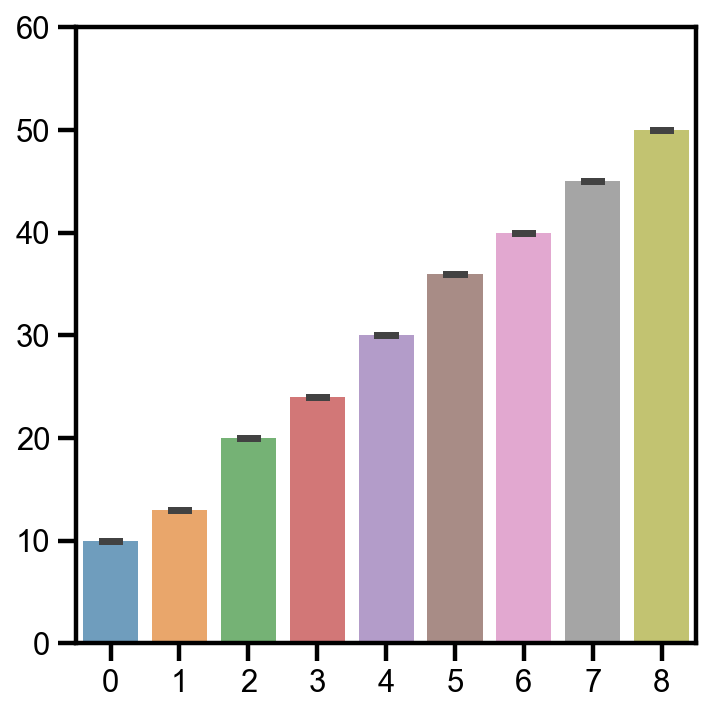

In [2]:
bar_df = pd.DataFrame(np.hstack([
    10 + np.zeros([SAMPLE_SIZE, 1]), 
    13 + np.zeros([SAMPLE_SIZE, 1]), 
    20 + np.zeros([SAMPLE_SIZE, 1]), 
    24 + np.zeros([SAMPLE_SIZE, 1]), 
    30 + np.zeros([SAMPLE_SIZE, 1]), 
    36 + np.zeros([SAMPLE_SIZE, 1]), 
    40 + np.zeros([SAMPLE_SIZE, 1]), 
    45 + np.zeros([SAMPLE_SIZE, 1]), 
    50 + np.zeros([SAMPLE_SIZE, 1]),
]))

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    bar_df,
    errorbar=BAR_ERRORBAR,
    capsize=BAR_CAPSIZE,
    linewidth=BAR_LINEWIDTH,
    edgecolor=BAR_EDGECOLOR,
    alpha=BAR_ALPHA,
    width=BAR_WIDTH,
    ax=ax,
)
# ax.set_box_aspect(2)
ax.set_ylim(0, 60)

In [3]:
def get_size_of_effect(series):
    # get permutations of all items as 2d array
    comb_arr = itertools.permutations(series, 2)
    comb_arr = np.array(list(comb_arr))
    # calculate size of effect for each permutation as series
    effect = np.diff(comb_arr).reshape(-1) / comb_arr[:, 0]
    effect = pd.Series(effect)
    return effect


def _get_lie_factor(viz_series, val_series):
    return get_size_of_effect(viz_series) / get_size_of_effect(val_series)


def get_lie_factor(viz_series, val_series):
    return viz_series / val_series

In [4]:
control1_val_series = pd.Series(np.array([10, 13, 20, 24, 30, 36, 40, 45, 50]))
control1_val_series.name = 'Data Value'
control1_val_series

0    10
1    13
2    20
3    24
4    30
5    36
6    40
7    45
8    50
Name: Data Value, dtype: int64

In [5]:
control1_viz_df = pd.read_csv(os.path.join(DATA_DIR, MISUSED_BAR_DIR, 'control', 'control_fig1.csv'), header=None, index_col=0)
control1_viz_df = control1_viz_df.reset_index(drop=True)
control1_viz_series = control1_viz_df.iloc[:, 0]
control1_viz_series.name = 'Visual Value'
control1_viz_series

0     9.868491
1    12.887194
2    19.898377
3    23.890856
4    29.928263
5    35.868292
6    39.860771
7    44.924403
8    49.890657
Name: Visual Value, dtype: float64

In [6]:
lie_factor_df = _get_lie_factor(control1_viz_series, control1_val_series)

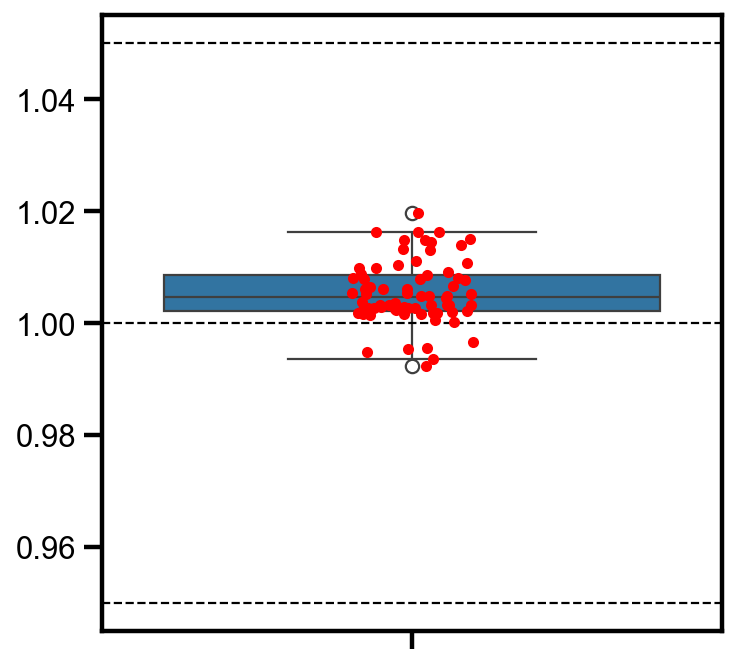

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(
    lie_factor_df,
    ax=ax,
    log_scale=False,
)
sns.stripplot(
    lie_factor_df,
    ax=ax,
    color='r',
)
ax.axhline(1, color='k', ls='--', lw=1)
ax.axhline(1.05, color='k', ls='--', lw=1)
ax.axhline(0.95, color='k', ls='--', lw=1)

(-5.0, 1.5)

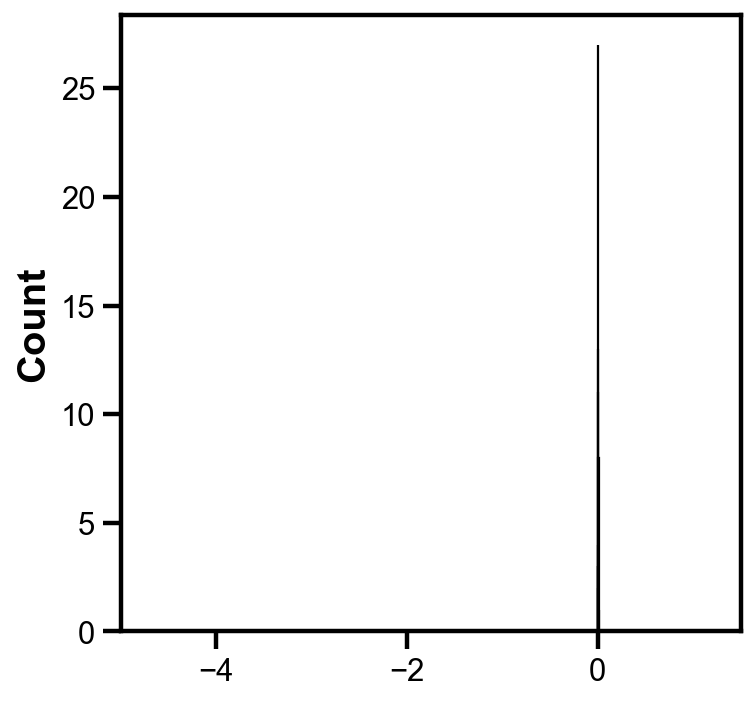

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(
    np.log10(lie_factor_df),
    ax=ax,
)
ax.set_xlim(-5, 1.5)

### Control 2

(0.0, 140.0)

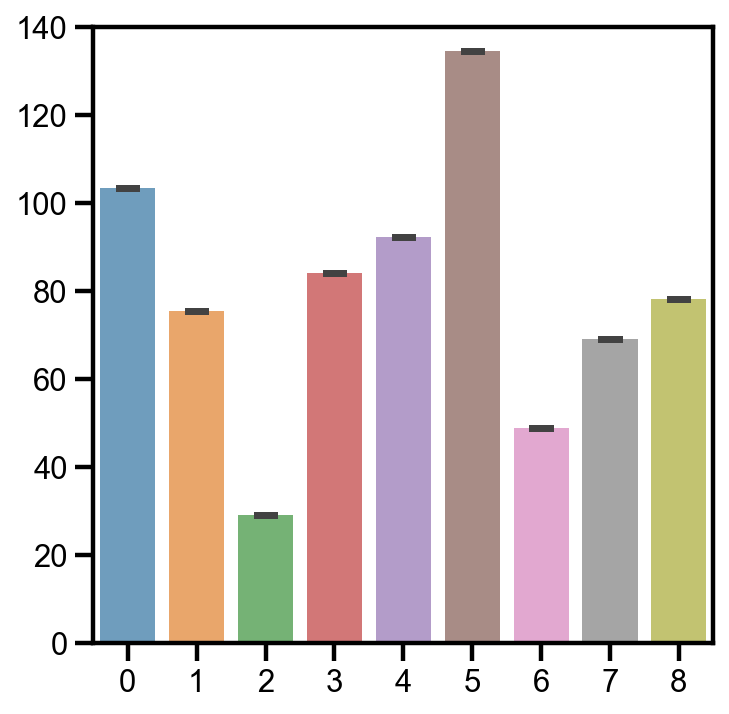

In [9]:
bar_df = pd.DataFrame(np.hstack([
    103.4 + np.zeros([SAMPLE_SIZE, 1]), 
    75.6 + np.zeros([SAMPLE_SIZE, 1]), 
    29.2 + np.zeros([SAMPLE_SIZE, 1]), 
    84.1 + np.zeros([SAMPLE_SIZE, 1]), 
    92.3 + np.zeros([SAMPLE_SIZE, 1]), 
    134.6 + np.zeros([SAMPLE_SIZE, 1]), 
    48.9 + np.zeros([SAMPLE_SIZE, 1]), 
    69.3 + np.zeros([SAMPLE_SIZE, 1]), 
    78.3 + np.zeros([SAMPLE_SIZE, 1]),
]))

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    bar_df,
    errorbar=BAR_ERRORBAR,
    capsize=BAR_CAPSIZE,
    linewidth=BAR_LINEWIDTH,
    edgecolor=BAR_EDGECOLOR,
    alpha=BAR_ALPHA,
    width=BAR_WIDTH,
    ax=ax,
)
# ax.set_box_aspect(2)
ax.set_ylim(0, 140)

In [10]:
control2_val_series = pd.Series(np.array([103.4, 75.6, 29.2, 84.1, 92.3, 134.6, 48.9, 69.3, 78.3]))
control2_val_series.name = 'Data Value'
control2_val_series

0    103.4
1     75.6
2     29.2
3     84.1
4     92.3
5    134.6
6     48.9
7     69.3
8     78.3
Name: Data Value, dtype: float64

In [11]:
control2_viz_df = pd.read_csv(os.path.join(DATA_DIR, MISUSED_BAR_DIR, 'control', 'control_fig2.csv'), header=None, index_col=0)
control2_viz_df = control2_viz_df.reset_index(drop=True)
control2_viz_series = control2_viz_df.iloc[:, 0]
control2_viz_series.name = 'Visual Value'
control2_viz_series

0    103.233107
1     75.285755
2     28.934049
3     83.919896
4     92.099609
5    134.361458
6     48.701688
7     68.923756
8     78.012326
Name: Visual Value, dtype: float64

In [12]:
lie_factor_df = _get_lie_factor(control2_viz_series, control2_val_series)

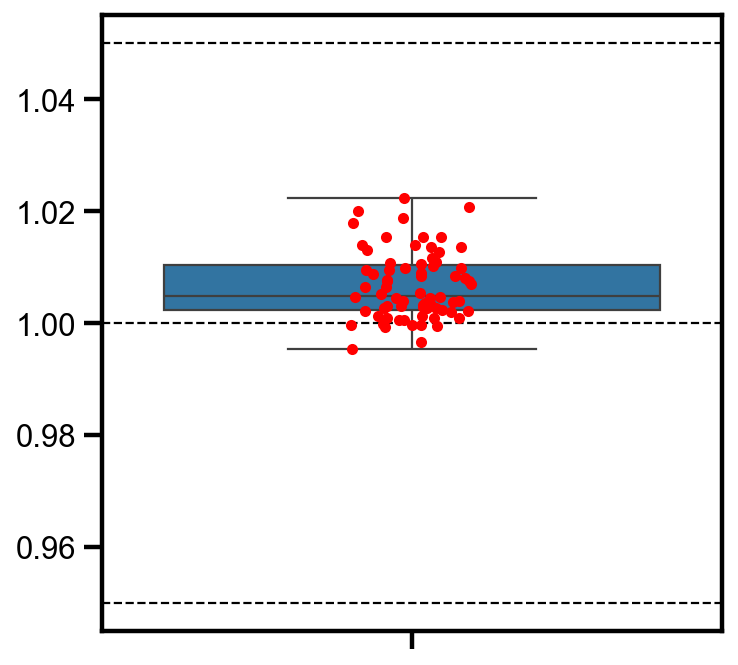

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(
    lie_factor_df,
    ax=ax,
    log_scale=False,
)
sns.stripplot(
    lie_factor_df,
    ax=ax,
    color='r',
)
ax.axhline(1, color='k', ls='--', lw=1)
ax.axhline(1.05, color='k', ls='--', lw=1)
ax.axhline(0.95, color='k', ls='--', lw=1)

(-5.0, 1.5)

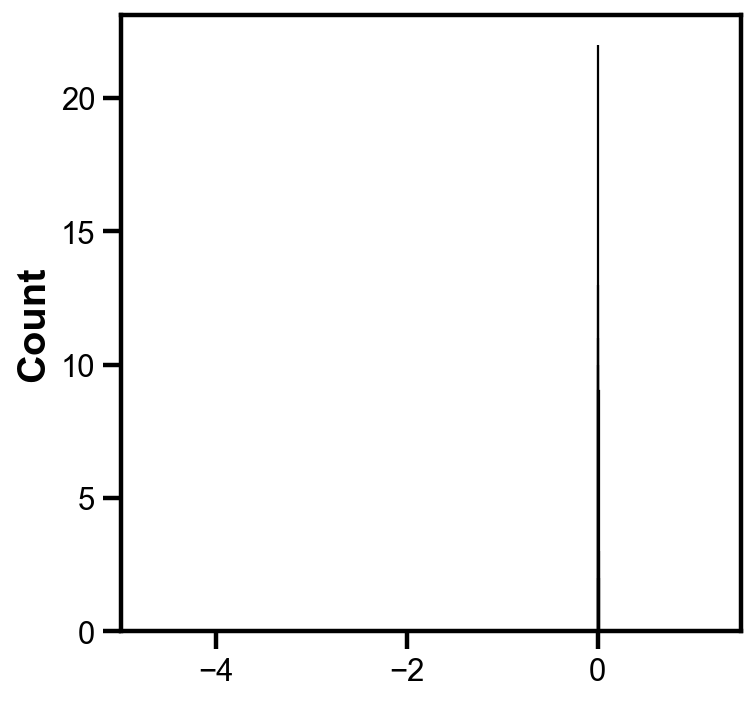

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(
    np.log10(lie_factor_df),
    ax=ax,
)
ax.set_xlim(-5, 1.5)

## Nature Biomedical Engineering

In [15]:
cv = lambda series: series.std() / series.mean()

### Bar-level data

In [16]:
X_LABEL = 'True Value'
Y_LABEL = 'Visualized Value'
ALPHA_MARK_LABEL = 'Mark Proportionality Constant'
ALPHA_DIFF_LABEL = 'Difference Proportionality Constant'

In [17]:
journals = [
    'nat_plants',
    'nat_biotechnol',
    'sci_immunol',
    # 'nature',
    # 'cell',
    'nat_cancer',
    'sci_transl_med',
    'nat_neurosci',
    'nat_cell_biol',
    'bioeng_transl_med',
    'sci_signal',
    'nat_nanotechnol',
    'nat_biomed_eng',
]
mistakes = [ZERO_SUBDIR, LOG_SUBDIR]
value_labels = [VAL_LABEL, VIZ_LABEL]
value_label_labels = [X_LABEL, Y_LABEL]

zero_bar_df_list = []
log_bar_df_list = []
for journal in journals:
    mistake_zero_bar_df_list = []
    mistake_log_bar_df_list = []
    for mistake in mistakes:
        for j, value_label in enumerate(value_labels):
            # get filepaths
            filepath = os.path.join(DATA_DIR, MISUSED_BAR_DIR, journal, mistake)
            filenames = os.listdir(filepath)
            filenames = pd.Series(filenames)
            filenames = filenames[filenames.str.contains(CSV_FILEEXT) & filenames.str.contains(value_label)]
            filenames = filenames.reset_index(drop=True)
            fignames = filenames.str.slice(stop=-8)
            fig_fullids = fignames.str.replace('fig', '')
            filepaths = filepath + os.sep + filenames
            # read individual csv
            raw_df_dict = {}
            for i, filepath in enumerate(filepaths):
                bar_df_ = pd.read_csv(filepath, header=None, index_col=0)
                bar_df_ = bar_df_.reset_index(drop=True)
                # bar_df_.columns = [value_label]
                bar_df_.columns = [value_label_labels[j]]
                # add metadata
                doi, _, figid = fig_fullids[i].split('_')
                bar_df_['Journal'] = journal
                bar_df_['DOI'] = doi
                bar_df_['Mistake'] = mistake
                bar_df_['Fig ID'] = figid
                raw_df_dict[fignames[i]] = bar_df_
            
            # construct mistake-level df
            mistake_level_bar_df = pd.concat(raw_df_dict)
            if mistake == ZERO_SUBDIR:
                mistake_zero_bar_df_list.append(mistake_level_bar_df)
            elif mistake == LOG_SUBDIR:
                mistake_log_bar_df_list.append(mistake_level_bar_df)
            else:
                raise ValueError
    # construct journal-level df
    # zero
    journal_zero_bar_df = mistake_zero_bar_df_list[0].copy()
    journal_zero_bar_df[Y_LABEL] = mistake_zero_bar_df_list[1][Y_LABEL]
    journal_zero_bar_df[ALPHA_MARK_LABEL] = journal_zero_bar_df[Y_LABEL] / journal_zero_bar_df[X_LABEL]
    zero_bar_df_list.append(journal_zero_bar_df)
    # log
    journal_log_bar_df = mistake_log_bar_df_list[0].copy()
    journal_log_bar_df[Y_LABEL] = mistake_log_bar_df_list[1][Y_LABEL]
    journal_log_bar_df[ALPHA_MARK_LABEL] = journal_log_bar_df[Y_LABEL] / journal_log_bar_df[X_LABEL]
    log_bar_df_list.append(journal_log_bar_df)

# construct overall df
zero_bar_df = pd.concat(zero_bar_df_list)
log_bar_df = pd.concat(log_bar_df_list)
bar_df = pd.concat([zero_bar_df, log_bar_df])
bar_df

True Value         Journal  \
10.1038:s41477-023-01527-5_zero_fig3 0      0.860656      nat_plants   
                                     1      0.840984      nat_plants   
                                     2      0.647541      nat_plants   
                                     3      0.804918      nat_plants   
                                     4      0.709836      nat_plants   
...                                              ...             ...   
10.1038:s41551-023-01143-w_log_fig1  11  1556.325877  nat_biomed_eng   
                                     12  1537.143957  nat_biomed_eng   
                                     13    20.026995  nat_biomed_eng   
                                     14  4578.067864  nat_biomed_eng   
                                     15  4044.103502  nat_biomed_eng   

                                                                DOI Mistake  \
10.1038:s41477-023-01527-5_zero_fig3 0   10.1038:s41477-023-01527-5    zero   
                                     1   10.1038:s41477-023-01527-5    zero   
                                     2   10.1038:s41477-023-01527-5    zero   
                                     3   10.1038:s41477-023-01527-5    zero   
                                     4   10.1038:s41477-023-01527-5    zero   
...                                                             ...     ...   
10.1038:s41551-023-01143-w_log_fig1  11  10.1038:s41551-023-01143-w     log   
                                     12  10.1038:s41551-023-01143-w     log   
                                     13  10.1038:s41551-023-01143-w     log   
                                     14  10.1038:s41551-023-01143-w     log   
                                     15  10.1038:s41551-023-01143-w     log   

                                        Fig ID  Visualized Value  \
10.1038:s41477-023-01527-5_zero_fig3 0       3          0.651639   
                                     1       3          0.602459   
                                     2       3          0.118852   
                                     3       3          0.512295   
                                     4       3          0.274590   
...                                        ...               ...   
10.1038:s41551-023-01143-w_log_fig1  11      1          0.730700   
                                     12      1          0.728905   
                                     13      1          0.100539   
                                     14      1          0.886894   
                                     15      1          0.868941   

                                         Mark Proportionality Constant  
10.1038:s41477-023-01527-5_zero_fig3 0                        0.757143  
                                     1                        0.716374  
                                     2                        0.183544  
                                     3                        0.636456  
                                     4                        0.386836  
...                                                                ...  
10.1038:s41551-023-01143-w_log_fig1  11                       0.000470  
                                     12                       0.000474  
                                     13                       0.005020  
                                     14                       0.000194  
                                     15                       0.000215  

[8020 rows x 7 columns]

## Pairwise permutation-level metric

In [18]:
def perm_rel_change(df, label):
    perm_arr = itertools.permutations(df[label].reset_index(drop=True), 2)
    perm_arr = np.array(list(perm_arr))
    rel_change = (perm_arr[:, 1] - perm_arr[:, 0]) / perm_arr[:, 0]
    rel_change = pd.Series(rel_change)
    return pd.DataFrame(perm_arr), rel_change

In [19]:
def perm_rel_change(df, label):
    perm_arr = itertools.permutations(df[label].reset_index(drop=True), 2)
    perm_arr = pd.DataFrame(np.array(list(perm_arr)))
    return perm_arr

In [20]:
L_df_list = []
fig_id = np.unique(bar_df.index.get_level_values(0))
for i in range(len(fig_id)):
    df = bar_df[bar_df.index.get_level_values(0) == fig_id[i]]
    
    # generate permutations and their respective x, y values
    L_df_ = pd.concat(
        [
            perm_rel_change(df, X_LABEL), 
            perm_rel_change(df, Y_LABEL),
        ], 
        axis=1
    )
    L_df_.columns = ['x_1', 'x_2', 'y_1', 'y_2']

    # store bar id
    L_df_[['Bar 1 ID', 'Bar 2 ID']] = perm_rel_change(bar_df[bar_df.index.get_level_values(0) == fig_id[i]].reset_index(), 'level_1')
    
    # compute lie factor of relative change
    L_df_['E_x_12'] = (L_df_['x_1'] - L_df_['x_2']) / L_df_['x_2']
    L_df_['E_y_12'] = (L_df_['y_1'] - L_df_['y_2']) / L_df_['y_2']
    L_df_['L_12'] = L_df_['E_y_12'] / L_df_['E_x_12']
    L_df_['log L_12'] = np.log10(L_df_['L_12'])

    # compute GDI
    L_df_['GDI_12'] = 100 * (L_df_['L_12'] - 1)

    # compute lie factor of fold change
    L_df_['F_12'] = (L_df_['x_1'] / L_df_['x_2']) / (L_df_['y_1'] / L_df_['y_2'])
    L_df_['log F_12'] = np.log10(L_df_['F_12'])

    # compute RGD
    L_df_['RGD_12'] = L_df_['L_12'] - 1

    # store meta data
    L_df_['Journal'] = df['Journal'][0]
    L_df_['DOI'] = df['DOI'][0]
    L_df_['Mistake'] = df['Mistake'][0]
    L_df_['Fig ID'] = df['Fig ID'][0]
    L_df_list.append(L_df_)
L_df = pd.concat(L_df_list, ignore_index=True)
L_df

,x_1,x_2,y_1,y_2,Bar 1 ID,Bar 2 ID,E_x_12,E_y_12,L_12,log L_12,GDI_12,F_12,log F_12,RGD_12,Journal,DOI,Mistake,Fig ID
0,0.941271,17.800504,0.352212,0.803540,0,1,-0.947121,-0.561674,0.593033,-0.226921,-40.696707,0.120638,-0.918515,-0.406967,bioeng_transl_med,10.1002:btm2.10487,log,1
1,0.941271,0.297195,0.352212,0.175221,0,2,2.167186,1.010101,0.466089,-0.331531,-53.391128,1.575635,0.197456,-0.533911,bioeng_transl_med,10.1002:btm2.10487,log,1
2,0.941271,3.977009,0.352212,0.573451,0,3,-0.763322,-0.385802,0.505426,-0.296343,-49.457437,0.385345,-0.414150,-0.494574,bioeng_transl_med,10.1002:btm2.10487,log,1
3,17.800504,0.941271,0.803540,0.352212,1,0,17.911138,1.281407,0.071542,-1.145436,-92.845753,8.289243,0.918515,-0.928458,bioeng_transl_med,10.1002:btm2.10487,log,1
4,17.800504,0.297195,0.803540,0.175221,1,2,58.895093,3.585859,0.060886,-1.215486,-93.911448,13.060824,1.115971,-0.939114,bioeng_transl_med,10.1002:btm2.10487,log,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111211,1331.015174,786.004146,0.795732,0.742378,2,1,0.693395,0.071869,0.103647,-0.984441,-89.635255,1.579853,0.198617,-0.896353,sci_transl_med,10.1126:scitranslmed.adi9867,log,2
111212,1331.015174,437.041699,0.795732,0.682927,2,3,2.045511,0.165179,0.080752,-1.092848,-91.924825,2.613772,0.417268,-0.919248,sci_transl_med,10.1126:scitranslmed.adi9867,log,2
111213,437.041699,2504.337233,0.682927,0.859756,3,0,-0.825486,-0.205674,0.249155,-0.603531,-75.084527,0.219701,-0.658169,-0.750845,sci_transl_med,10.1126:scitranslmed.adi9867,log,2
111214,437.041699,786.004146,0.682927,0.742378,3,1,-0.443970,-0.080082,0.180377,-0.743818,-81.962274,0.604434,-0.218651,-0.819623,sci_transl_med,10.1126:scitranslmed.adi9867,log,2


### Only median of each plot

- Bias in different number of bars
  - If include every point in each plot, graphs with more plots will have an advantage by pairwise permutation (n(n-1)).
  - Taking median of each plot?
- Bias in different number of plots for the same type of quantity
  - If include every similar plot, similar deviation is exaggerated
  - Taking median among all plots?
  - Do we have enough data point for journal level analysis?
- Put raw biased plots in supplemental information

In [21]:
L_df.groupby(['DOI', 'Mistake', 'Fig ID', 'Journal']).median()

x_1  \
DOI                          Mistake Fig ID Journal                          
10.1002:btm2.10487           log     1      bioeng_transl_med     2.459140   
                                     2      bioeng_transl_med     6.461362   
10.1002:btm2.10499           zero    1      bioeng_transl_med    23.125241   
                                     2      bioeng_transl_med    17.704626   
                                     3      bioeng_transl_med    13.212996   
...                                                                    ...   
10.1126:scitranslmed.adi7244 zero    1      sci_transl_med       48.135048   
                                     2      sci_transl_med       88.396694   
                                     3      sci_transl_med       68.875639   
10.1126:scitranslmed.adi9867 log     1      sci_transl_med       55.014111   
                                     2      sci_transl_med     1058.509660   

                                                                       x_2  \
DOI                          Mistake Fig ID Journal                          
10.1002:btm2.10487           log     1      bioeng_transl_med     2.459140   
                                     2      bioeng_transl_med     6.461362   
10.1002:btm2.10499           zero    1      bioeng_transl_med    23.125241   
                                     2      bioeng_transl_med    17.704626   
                                     3      bioeng_transl_med    13.212996   
...                                                                    ...   
10.1126:scitranslmed.adi7244 zero    1      sci_transl_med       48.135048   
                                     2      sci_transl_med       88.396694   
                                     3      sci_transl_med       68.875639   
10.1126:scitranslmed.adi9867 log     1      sci_transl_med       55.014111   
                                     2      sci_transl_med     1058.509660   

                                                                    y_1  \
DOI                          Mistake Fig ID Journal                       
10.1002:btm2.10487           log     1      bioeng_transl_med  0.462832   
                                     2      bioeng_transl_med  0.448692   
10.1002:btm2.10499           zero    1      bioeng_transl_med  0.366089   
                                     2      bioeng_transl_med  0.423488   
                                     3      bioeng_transl_med  0.328520   
...                                                                 ...   
10.1126:scitranslmed.adi7244 zero    1      sci_transl_med     0.604502   
                                     2      sci_transl_med     0.439669   
                                     3      sci_transl_med     0.471891   
10.1126:scitranslmed.adi9867 log     1      sci_transl_med     0.474252   
                                     2      sci_transl_med     0.769055   

                                                                    y_2  \
DOI                          Mistake Fig ID Journal                       
10.1002:btm2.10487           log     1      bioeng_transl_med  0.462832   
                                     2      bioeng_transl_med  0.448692   
10.1002:btm2.10499           zero    1      bioeng_transl_med  0.366089   
                                     2      bioeng_transl_med  0.423488   
                                     3      bioeng_transl_med  0.328520   
...                                                                 ...   
10.1126:scitranslmed.adi7244 zero    1      sci_transl_med     0.604502   
                                     2      sci_transl_med     0.439669   
                                     3      sci_transl_med     0.471891   
10.1126:scitranslmed.adi9867 log     1      sci_transl_med     0.474252   
                                     2      sci_transl_med     0.769055   

                                                               Bar 1 ID  \
DOI           

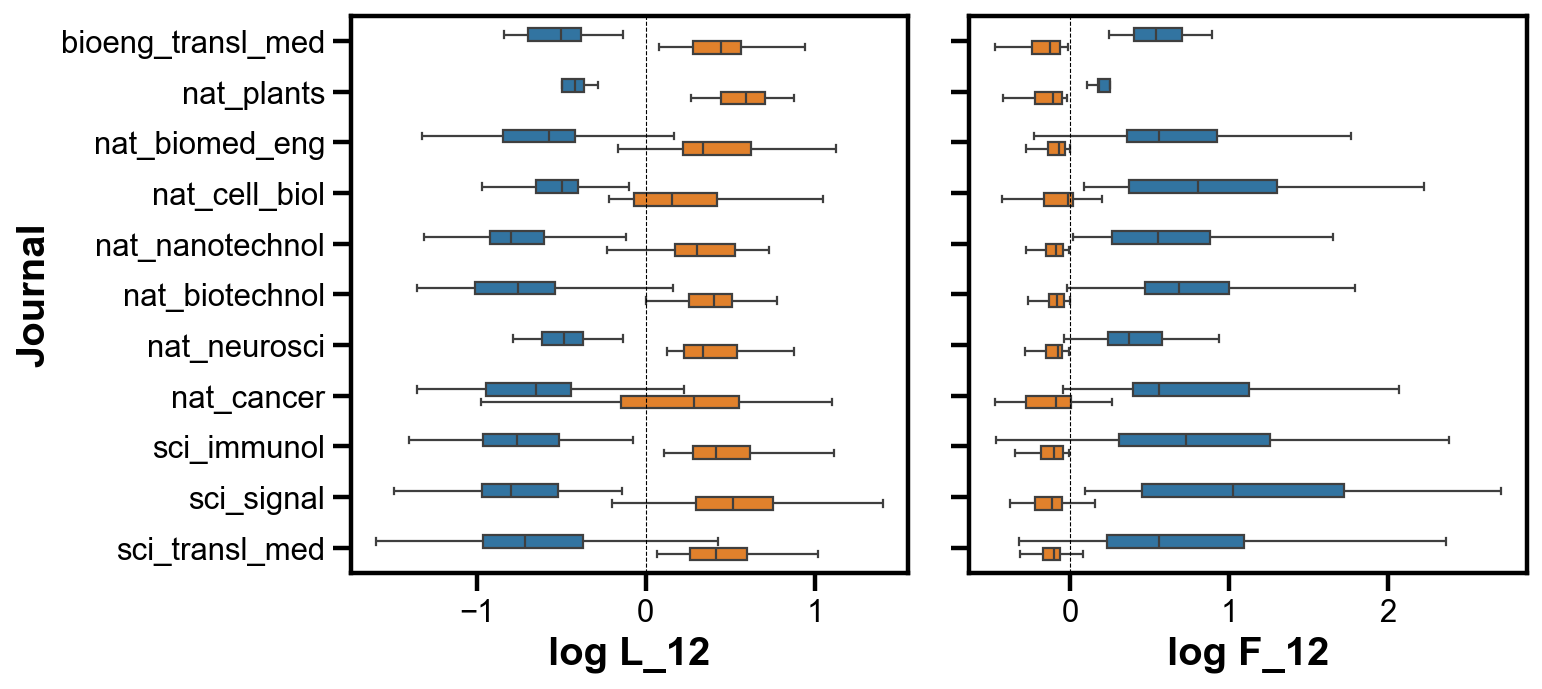

In [22]:
row = 1
col = 2
scale = 3
fig, axs = plt.subplots(row, col, figsize=(10, 5), sharey=True)
sns.boxplot(
    L_df.groupby(['DOI', 'Mistake', 'Fig ID', 'Journal']).median(), 
    x='log L_12',
    y='Journal',
    hue='Mistake', 
    ax=axs[0],
    width=0.5,
    legend=False,
    showfliers=False,
)
sns.boxplot(
    L_df[L_df['x_1'] > L_df['x_2']].groupby(['DOI', 'Mistake', 'Fig ID', 'Journal']).median(),
    x='log F_12', 
    y='Journal',
    hue='Mistake', 
    ax=axs[1],
    width=0.5,
    legend=False,
    showfliers=False,
)
for i in range(col):
    axs[i].axvline(0, color='k', ls='--', lw=0.5, zorder=999)
    axs[i].set_box_aspect(1)
plt.tight_layout()

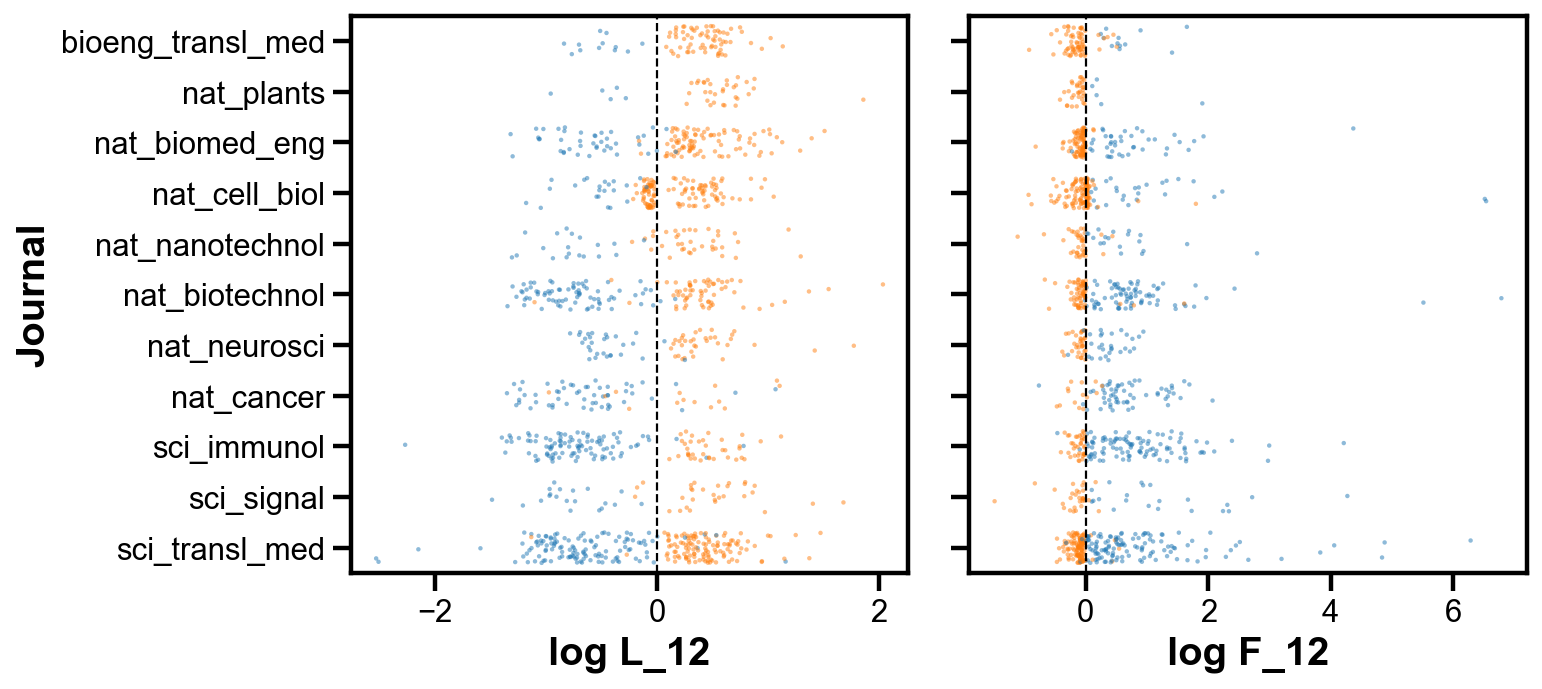

In [23]:
row = 1
col = 2
scale = 3
fig, axs = plt.subplots(row, col, figsize=(10, 5), sharey=True)
sns.stripplot(
    L_df.groupby(['DOI', 'Mistake', 'Fig ID', 'Journal']).median(), 
    x='log L_12',
    y='Journal',
    hue='Mistake', 
    alpha=0.5,
    size=2,
    jitter=0.3,
    ax=axs[0],
    legend=False,
)
sns.stripplot(
    L_df[L_df['x_1'] > L_df['x_2']].groupby(['DOI', 'Mistake', 'Fig ID', 'Journal']).median(),
    x='log F_12', 
    y='Journal',
    hue='Mistake', 
    alpha=0.5,
    size=2,
    jitter=0.3,
    ax=axs[1],
    legend=False,
)
for i in range(col):
    axs[i].axvline(0, color='k', ls='--', lw=1, zorder=999)
    axs[i].set_box_aspect(1)
plt.tight_layout()

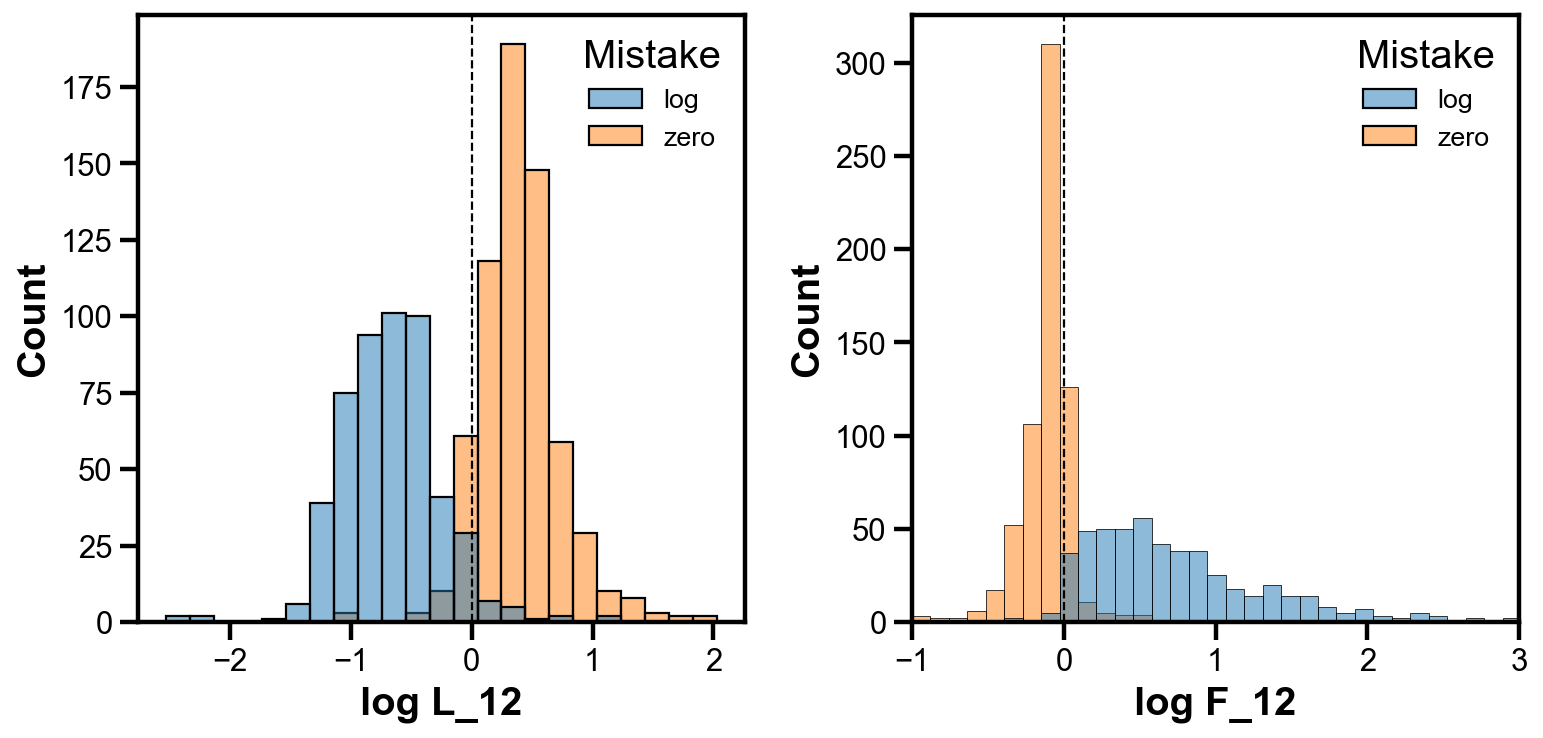

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(
    L_df.groupby(['DOI', 'Mistake', 'Fig ID', 'Journal']).median(), 
    x='log L_12', 
    hue='Mistake', 
    ax=axs[0],
)
sns.histplot(
    L_df[L_df['x_1'] > L_df['x_2']].groupby(['DOI', 'Mistake', 'Fig ID', 'Journal']).median(),
    x='log F_12', 
    hue='Mistake', 
    ax=axs[1],
)
axs[1].set_xlim(-1, 3)
for i in range(2):
    axs[i].set_box_aspect(1)
    axs[i].axvline(0, color='k', lw=1, ls='--')
plt.tight_layout()

## Graph-level metric

In [29]:
grouped_alpha = (bar_df[ALPHA_MARK_LABEL]).groupby(bar_df.index.get_level_values(0))
grouped_alpha_inverse = (1 / bar_df[ALPHA_MARK_LABEL]).groupby(bar_df.index.get_level_values(0))

In [30]:
cv_df = grouped_alpha.std() / grouped_alpha.mean()
cv_df = cv_df.to_frame()
cv_df.columns = ['CV alpha_i']
cv_df['log CV alpha_i'] = np.log10(cv_df['CV alpha_i'])

cv_df['CV alpha_i inverse'] = grouped_alpha_inverse.std() / grouped_alpha_inverse.mean()
cv_df['log CV alpha_i inverse'] = np.log10(cv_df['CV alpha_i inverse'])

cv_df['Mean CV alpha_i'] = (cv_df['CV alpha_i'] + cv_df['CV alpha_i inverse']) / 2
cv_df['log Mean CV alpha_i'] = np.log10(cv_df['Mean CV alpha_i'])

cv_df['IQR over median alpha_i'] = (grouped_alpha.quantile(0.75) - grouped_alpha.quantile(0.25)) / grouped_alpha.median()
cv_df['log IQR over median alpha_i'] = np.log10(cv_df['IQR over median alpha_i'])

cv_df['IQR over median alpha_i inverse'] = (grouped_alpha_inverse.quantile(0.75) - grouped_alpha_inverse.quantile(0.25)) / grouped_alpha_inverse.median()
cv_df['log IQR over median alpha_i inverse'] = np.log10(cv_df['IQR over median alpha_i inverse'])

cv_df['Mean IQR over median alpha_i'] = (cv_df['IQR over median alpha_i'] + cv_df['IQR over median alpha_i inverse']) / 2
cv_df['log Mean IQR over median alpha_i'] = np.log10(cv_df['Mean IQR over median alpha_i'])

cv_df['MAD alpha_i'] = grouped_alpha.agg(lambda pop: np.median(np.abs(pop - np.median(pop)))) / grouped_alpha.median()
cv_df['log MAD alpha_i'] = np.log10(cv_df['MAD alpha_i'])

cv_df['MAD alpha_i inverse'] = grouped_alpha_inverse.agg(lambda pop: np.median(np.abs(pop - np.median(pop)))) / grouped_alpha_inverse.median()
cv_df['log MAD alpha_i inverse'] = np.log10(cv_df['MAD alpha_i inverse'])

cv_df['Mean MAD alpha_i'] = (cv_df['MAD alpha_i'] + cv_df['MAD alpha_i inverse']) / 2
cv_df['log Mean MAD alpha_i'] = np.log10(cv_df['Mean MAD alpha_i'])

# cv_df = pd.DataFrame(np.abs(np.log10(bar_df[ALPHA_MARK_LABEL]).groupby(bar_df.index.get_level_values(0)).std() / np.log10(bar_df[ALPHA_MARK_LABEL]).groupby(bar_df.index.get_level_values(0)).mean()))

# tag meta data
cv_df['Mistake'] = bar_df.groupby(bar_df.index.get_level_values(0))['Mistake'].unique().str.get(0)
cv_df

,CV alpha_i,log CV alpha_i,CV alpha_i inverse,log CV alpha_i inverse,Mean CV alpha_i,log Mean CV alpha_i,IQR over median alpha_i,log IQR over median alpha_i,IQR over median alpha_i inverse,log IQR over median alpha_i inverse,Mean IQR over median alpha_i,log Mean IQR over median alpha_i,MAD alpha_i,log MAD alpha_i,MAD alpha_i inverse,log MAD alpha_i inverse,Mean MAD alpha_i,log Mean MAD alpha_i,Mistake
10.1002:btm2.10487_log_fig1,0.845068,-0.073108,1.132176,0.053914,0.988622,-0.004970,1.190664,0.075789,1.730117,0.238076,1.460391,0.164469,0.634760,-0.197390,0.545305,-0.263361,0.590032,-0.229124,log
10.1002:btm2.10487_log_fig2,1.048477,0.020559,1.584681,0.199942,1.316579,0.119447,1.720471,0.235647,3.872882,0.588034,2.796676,0.446642,0.833423,-0.079135,0.762112,-0.117981,0.797767,-0.098124,log
10.1002:btm2.10499_zero_fig1,0.457477,-0.339630,0.572072,-0.242549,0.514775,-0.288383,0.760722,-0.118774,0.869892,-0.060535,0.815307,-0.088679,0.404966,-0.392581,0.355302,-0.449403,0.380134,-0.420063,zero
10.1002:btm2.10499_zero_fig2,0.139314,-0.856007,0.151607,-0.819280,0.145460,-0.837255,0.183955,-0.735289,0.173445,-0.760838,0.178700,-0.747876,0.087628,-1.057357,0.080568,-1.093837,0.084098,-1.075214,zero
10.1002:btm2.10499_zero_fig3,0.139831,-0.854397,0.136558,-0.864683,0.138195,-0.859509,0.205211,-0.687798,0.185312,-0.732097,0.195262,-0.709383,0.074777,-1.126234,0.069574,-1.157552,0.072175,-1.141611,zero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.1126:scitranslmed.adi7244_zero_fig1,0.198204,-0.702888,0.198204,-0.702888,0.198204,-0.702888,0.140151,-0.853403,0.140151,-0.853403,0.140151,-0.853403,0.140151,-0.853403,0.140151,-0.853403,0.140151,-0.853403,zero
10.1126:scitranslmed.adi7244_zero_fig2,0.701399,-0.154035,0.701399,-0.154035,0.701399,-0.154035,0.495964,-0.304550,0.495964,-0.304550,0.495964,-0.304550,0.495964,-0.304550,0.495964,-0.304550,0.495964,-0.304550,zero
10.1126:scitranslmed.adi7244_zero_fig3,0.468870,-0.328947,0.468870,-0.328947,0.468870,-0.328947,0.331541,-0.479462,0.331541,-0.479462,0.331541,-0.479462,0.331541,-0.479462,0.331541,-0.479462,0.331541,-0.479462,zero
10.1126:scitranslmed.adi9867_log_fig1,0.242860,-0.614644,0.286868,-0.542318,0.264864,-0.576977,0.223449,-0.650822,0.264978,-0.576790,0.244213,-0.612230,0.122944,-0.910291,0.109537,-0.960440,0.116241,-0.934642,log


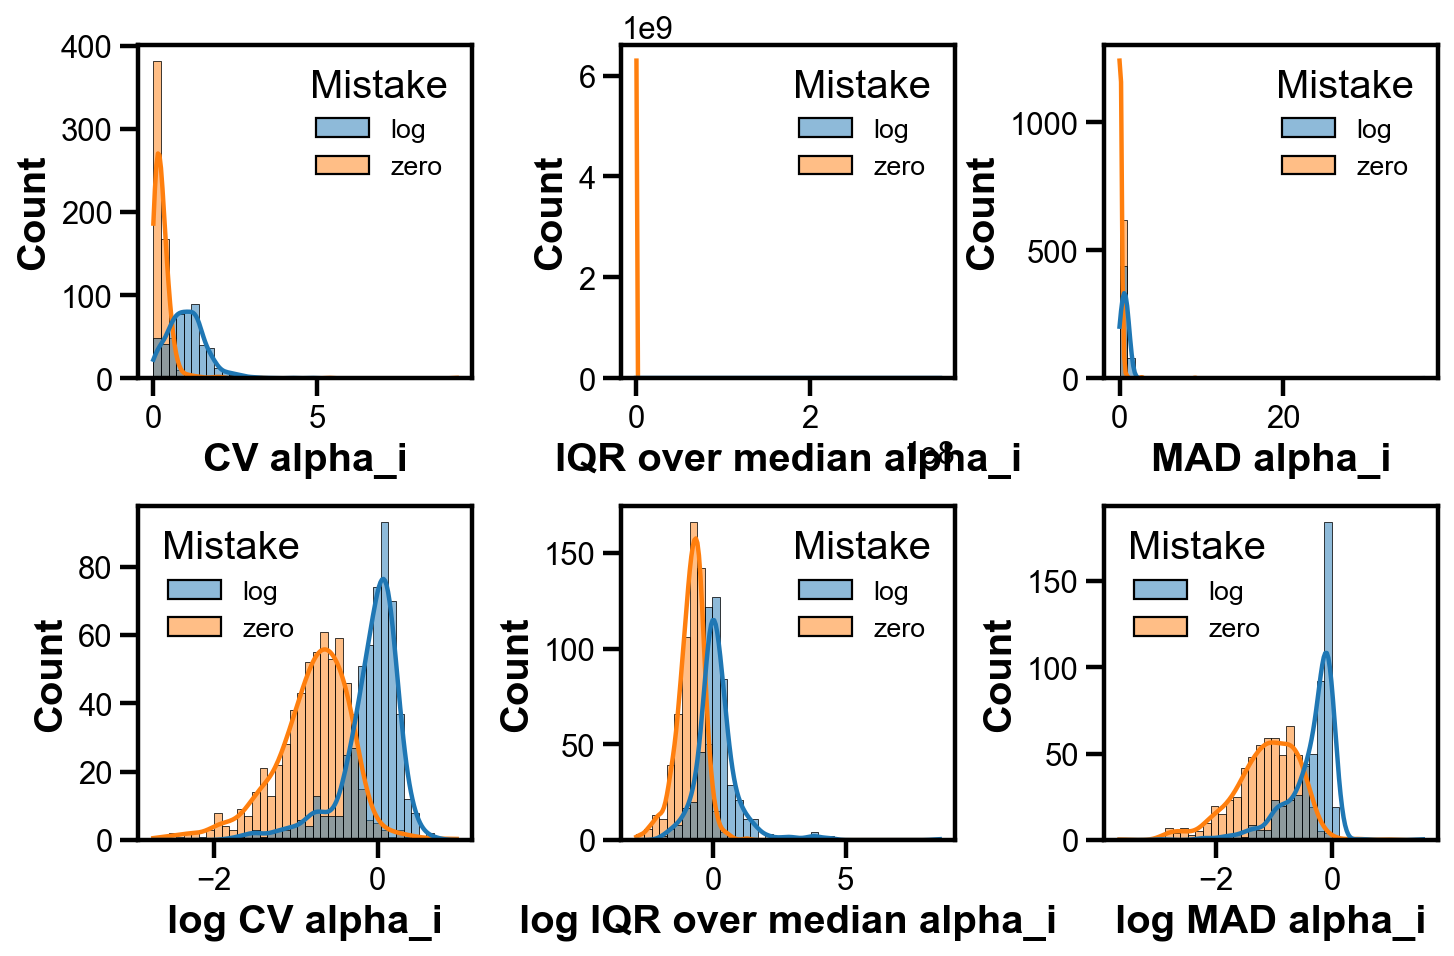

In [34]:
property_list = [
    'CV alpha_i',
    # 'CV alpha_i inverse',
    # 'Mean CV alpha_i',
    'IQR over median alpha_i',
    # 'IQR over median alpha_i inverse',
    # 'Mean IQR over median alpha_i',
    'MAD alpha_i',
    # 'MAD alpha_i inverse',
    # 'Mean MAD alpha_i',
]
row = 2
col = len(property_list)
scale = 3
fig, axs = plt.subplots(row, col, figsize=(col*scale, row*scale))
for col_i in range(col):
    sns.histplot(
        cv_df[cv_df['CV alpha_i'] > 0],
        x=property_list[col_i],
        hue='Mistake',
        bins=40,
        kde=True,
        # bins=np.linspace(-3.5, 3.5, 29),
        ax=axs[0, col_i],
    )
    sns.histplot(
        cv_df[cv_df['CV alpha_i'] > 0],
        x=f'log {property_list[col_i]}',
        hue='Mistake',
        bins=40,
        kde=True,
        # bins=np.linspace(-3.5, 3.5, 29),
        ax=axs[1, col_i],
    )
for col_i in range(col):
    for row_i in range(row):
        axs[row_i, col_i].set_box_aspect(1)
plt.tight_layout(pad=0.2)